In [ ]:
import os
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib 
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model
from functions import process_label_maps, process_model_area_mask, get_area_masks, generate_patches
from autoencoder import SimpleAutoencoder
from comparison_plots_functions import plot_comparisons

"


os.environ["OPENBLAS_NUM_THREADS"] = "16"
os.environ["NUM_THREADS"] = "16"
os.environ["OMP_NUM_THREADS"] = "16"



gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,"  , len(logical_gpus), "Logical GPUs")
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


total cores: 256
1 Physical GPUs, 1 Logical GPUs


2025-07-29 14:36:56.977378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14678 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:25:00.0, compute capability: 7.5


In [ ]:
bands=[31]
data_loc = "//"
mimi_data_folder = "/ippe/data/"
merra_folder = "/merra_data/"
matplotlib.rcParams.update({'font.size': 16})

In [ ]:
import json
with open(f"{data_loc}labeled_data/data.json", "r") as f:
    data = json.load(f)["data"]["image_results"]
labeled_data = pd.json_normalize(data)

labeled_data = pd.json_normalize(data)
filtered_data = labeled_data[labeled_data["user_id"] == "user"]

In [ ]:
label_folder = "/labeling_data/full_record_500/"
indices = [13, 14, 18, 21, 35, 43, 48 , 20+ 50, 28+ 50, 34+ 50, 38+ 50, 40+ 50, 44+ 50, 47+ 50, 121, 122, 131, 132, 137, 140, 143, 2+150, 8+150, 16+150, 20+150, 22+150, 35+150, 38+150, 41+150]
np.random.seed(100)
# indices = np.random.randint(200, 450, 50)
indices = np.arange(0, 499, 1) 
files = os.listdir(label_folder)
x_cao = []
dates_cao = []
masks_cao = []
lon_lats_cao = []
mod_min_cao = []

dates_to_plot = ["2008326", "2013337"]#["2000068", "2006059", "2008326", "2019333", "2020007"]
for i, file in enumerate(files):
    if i in indices:
        print(f"{i}/{len(files)}", end="\r")
        if file.split(".")[1][1:] in dates_to_plot:
            data = np.load(label_folder + file)#.items()
            dat = data["data"][:,:,0]
            lon = data["lon"]
            lat = data["lat"]
            mask = data["mask"]
            x_cao.append(dat)
            dates_cao.append(file.split(".")[1][1:])
            masks_cao.append(np.where(mask< 0.1, 1, 0))
            lon_lats_cao.append(np.array([lon, lat]))
            mod_min_cao.append(file.split(".")[2])

In [4]:

model_run_name = f"dnb_ice01_l95_z50_ps128_band31"
patch_size = 128
max_vals = np.load(f"{data_loc}models/patch_size128/filter128/max_val_{model_run_name}_2019-2023.npy")
min_vals = np.load(f"{data_loc}models/patch_size128/filter128/min_val_{model_run_name}_2019-2023.npy")
encoder = load_model(f"{mimi_data_folder}models/patch_size128/filter128/encoder_{model_run_name}.h5")
n_K = 7 
cluster = joblib.load(f"{data_loc}models/patch_size128/filter128/clustering/K{n_K}/cluster_{model_run_name}_filter128_K{n_K}.pkl" )
autoencoder_predict = SimpleAutoencoder(len(bands), 128, 128)
strides = 128//4

In [5]:
patches_cao, all_lon_patches_cao, all_lat_patches_cao, starts_cao, ends_cao, shapes_cao, n_patches_tot_cao, indices_cao = generate_patches([x for x in x_cao],
                                                                                                                                        masks_cao,
                                                                                                                                        lon_lats_cao,
                                                                                                                                        max_vals,
                                                                                                                                        min_vals,
                                                                                                                                        autoencoder_predict,
                                                                                                                                        strides=[1, strides, strides,1], 
                                                                                                                                        lon_lat_min_max=[-55, 65, 50, 82])

In [6]:
n_K = 7 
with tf.device('/CPU:0'):   
    encoded_patches_cao = encoder.predict(patches_cao, verbose=1)
    encoded_patches_flat_cao = encoded_patches_cao.reshape(encoded_patches_cao.shape[0], -1)


cluster = joblib.load(f"{data_loc}models/patch_size128/filter128/clustering/K{n_K}/cluster_{model_run_name}_filter128_K{n_K}.pkl" )
labels = cluster.predict(encoded_patches_flat_cao)

81/81 [==============================] - 2s 24ms/step


In [7]:
label_map, lon_map, lat_map = process_label_maps(labels,
                                                all_lon_patches_cao,
                                                all_lat_patches_cao,
                                                starts_cao,
                                                ends_cao,
                                                shapes_cao,
                                                indices_cao,
                                                n_K,
                                                n_patches_tot_cao,
                                                patch_size,
                                                strides,
                                                [3,6], 
                                                [], 
                                                size_thr_1=15, 
                                                size_thr_2=15)

model_areas = process_model_area_mask(range(len(lon_map)), lon_map, lat_map, indices_cao, label_map, [3,6], [], plot=False)


In [8]:
labeled_areas = get_area_masks(x_cao,
                                dates_cao,
                                mod_min_cao,
                                masks_cao,
                                filtered_data,
                                subpixel_resolution=2,
                                reduction=strides,
                                index_list=range(len(x_cao)),
                                plot=False,)

In [9]:
lookup_table = {"U": "MERRA2.wind_at_950hpa", 
                "V": "MERRA2.wind_at_950hpa",
                "AIRDENS": "MERRA2_400.inst3_3d_aer_Nv",
                "SO4": "MERRA2_400.inst3_3d_aer_Nv",
                "SS001": "MERRA2_400.inst3_3d_aer_Nv",
                "SS002": "MERRA2_400.inst3_3d_aer_Nv",
                "SS003": "MERRA2_400.inst3_3d_aer_Nv",
                "SS004": "MERRA2_400.inst3_3d_aer_Nv",
                "SS005": "MERRA2_400.inst3_3d_aer_Nv",
                "CLDTMP": "MERRA2_400.tavg1_2d_slv_Nx",
                "CLDPRS": "MERRA2_400.tavg1_2d_slv_Nx",
                "PS": "MERRA2_400.tavg1_2d_slv_Nx",
                "T2M": "MERRA2_400.tavg1_2d_slv_Nx",
                "TS": "MERRA2_400.tavg1_2d_slv_Nx",
                "T850": "MERRA2_400.tavg1_2d_slv_Nx",
                "U10M": "MERRA2_400.tavg1_2d_slv_Nx",
                "V10M": "MERRA2_400.tavg1_2d_slv_Nx",
                "ZLCL": "MERRA2_400.tavg1_2d_slv_Nx",
                "TQL": "MERRA2_400.tavg1_2d_slv_Nx",
                "TQV": "MERRA2_400.tavg1_2d_slv_Nx",
                "TQI": "MERRA2_400.tavg1_2d_slv_Nx",
                "TS": "MERRA2_400.tavg1_2d_slv_Nx",
                "QL":"MERRA2_400.inst3_3d_asm_Np",
                "QI":"MERRA2_400.inst3_3d_asm_Np",
                "T":"MERRA2_400.inst3_3d_asm_Np",
                "H":"MERRA2_400.inst3_3d_asm_Np",
                "PBLH": "MERRA2_400.tavg1_2d_flx_Nx",
                "PRECTOT": "MERRA2_400.tavg1_2d_flx_Nx",
                "PRECTOTCORR": "MERRA2_400.tavg1_2d_flx_Nx"
                }

date = "20230401"
var = "T"
ds = xr.open_dataset(f"{merra_folder}{date[:4]}/{lookup_table[var]}.{date}.SUB.nc")
lon_grid, lat_grid = np.meshgrid(ds.lon.values, ds.lat.values)

81/81 [==============================] - 0s 3ms/step
20081121
20081121


/uio/kant/geo-geofag-u1/fslippe/master_project/code/comparison_plots_functions.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # date_final = datetime_obj.split(" ")[0] + "T" + datetime_obj.split(" ")[1]


/uio/kant/geo-geofag-u1/fslippe/master_project/paper/figures/comparisons/CAO_pred_comparison_Mthr3.75_2008-11-21_21:00:00_skip1.png
saved fig: 0


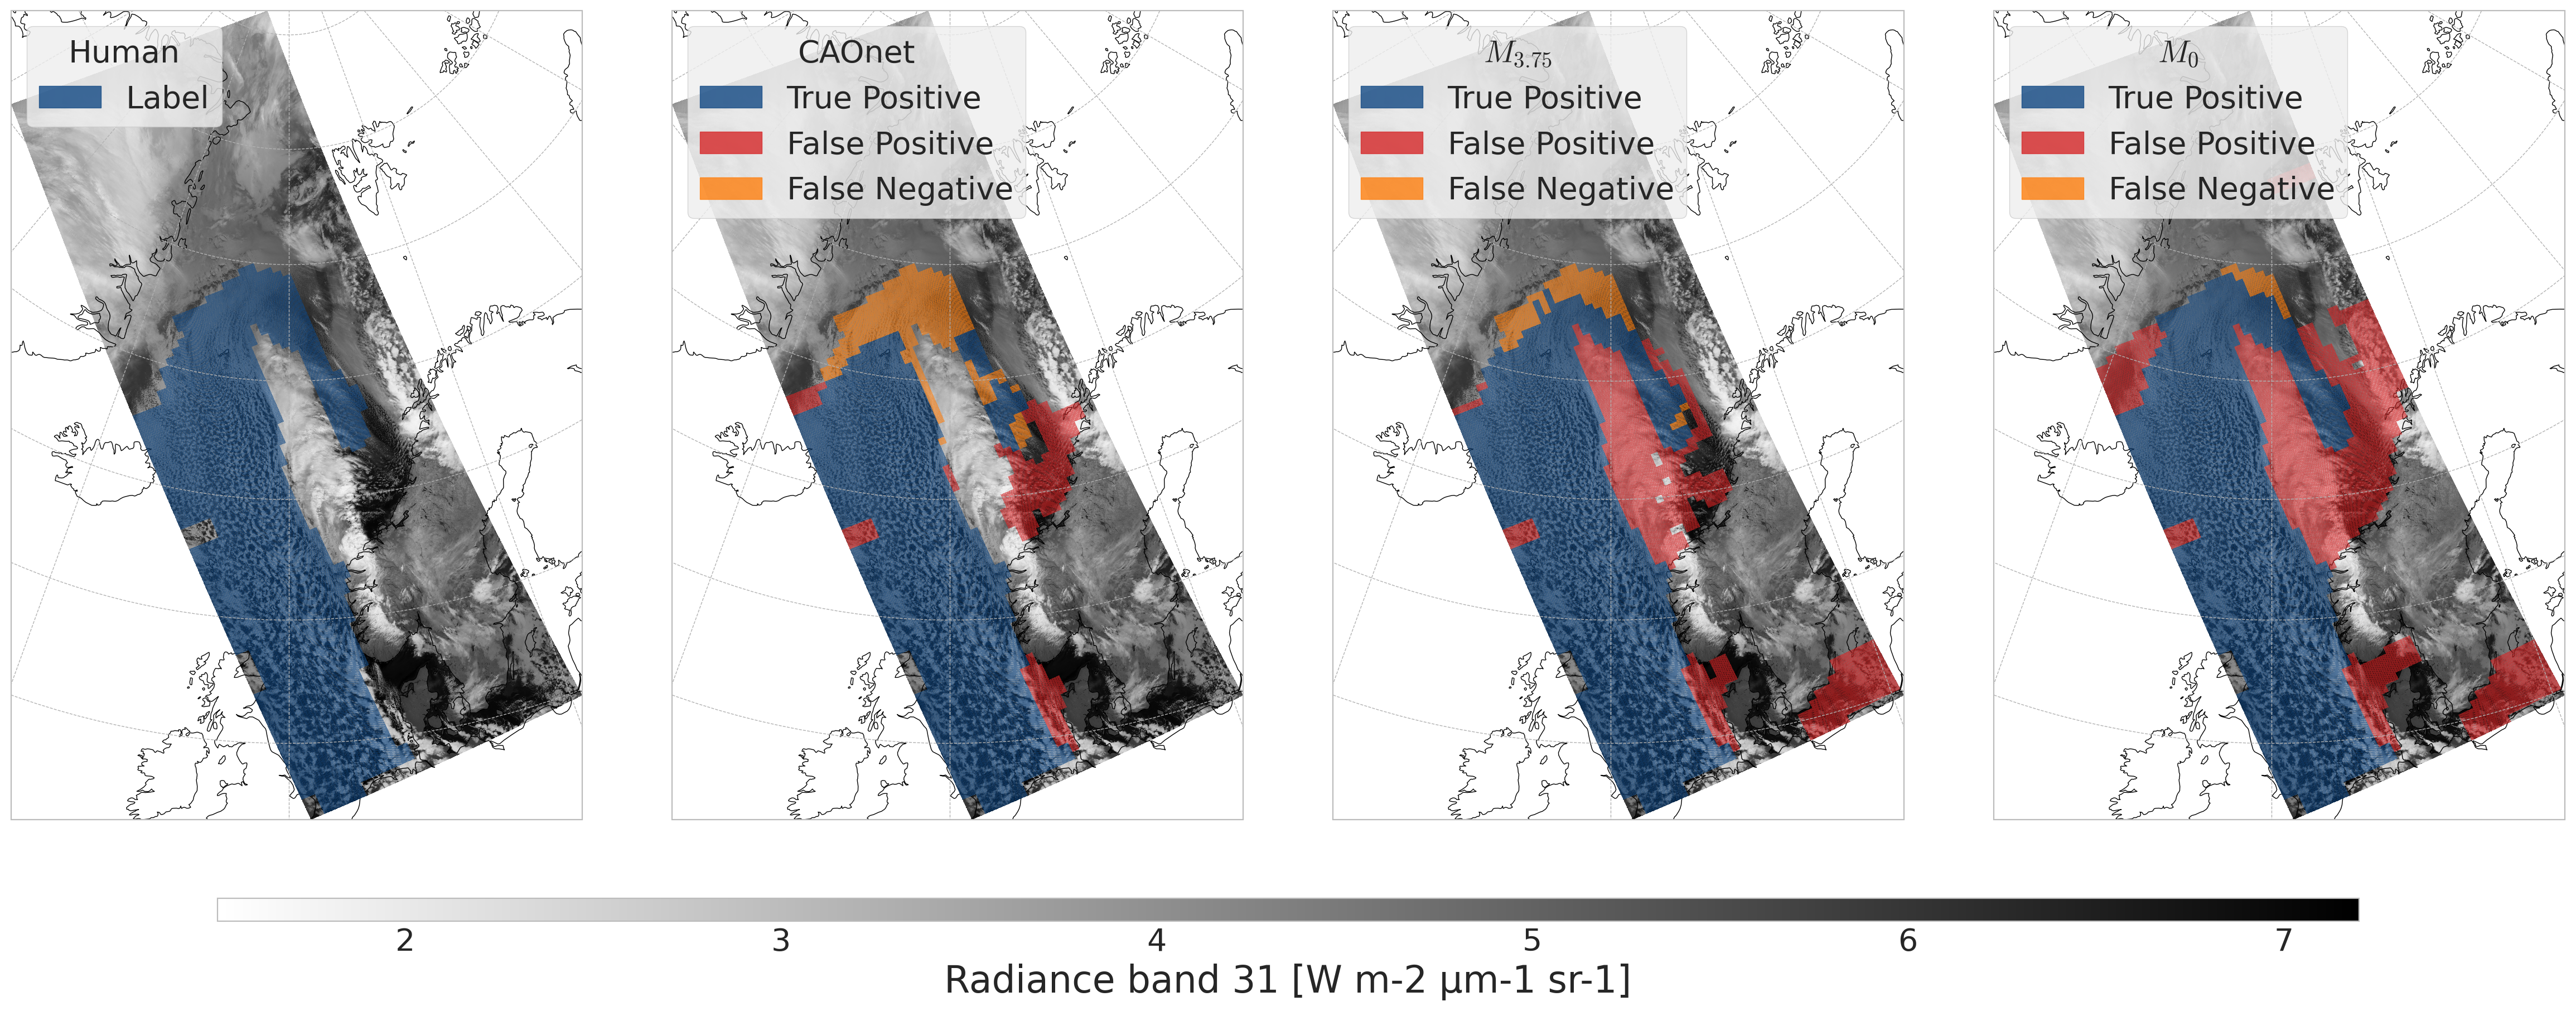

20131203
20131203


/uio/kant/geo-geofag-u1/fslippe/master_project/code/comparison_plots_functions.py:258: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # date_final = datetime_obj.split(" ")[0] + "T" + datetime_obj.split(" ")[1]


/uio/kant/geo-geofag-u1/fslippe/master_project/paper/figures/comparisons/CAO_pred_comparison_Mthr3.75_2013-12-03_22:50:00_skip1.png
saved fig: 1


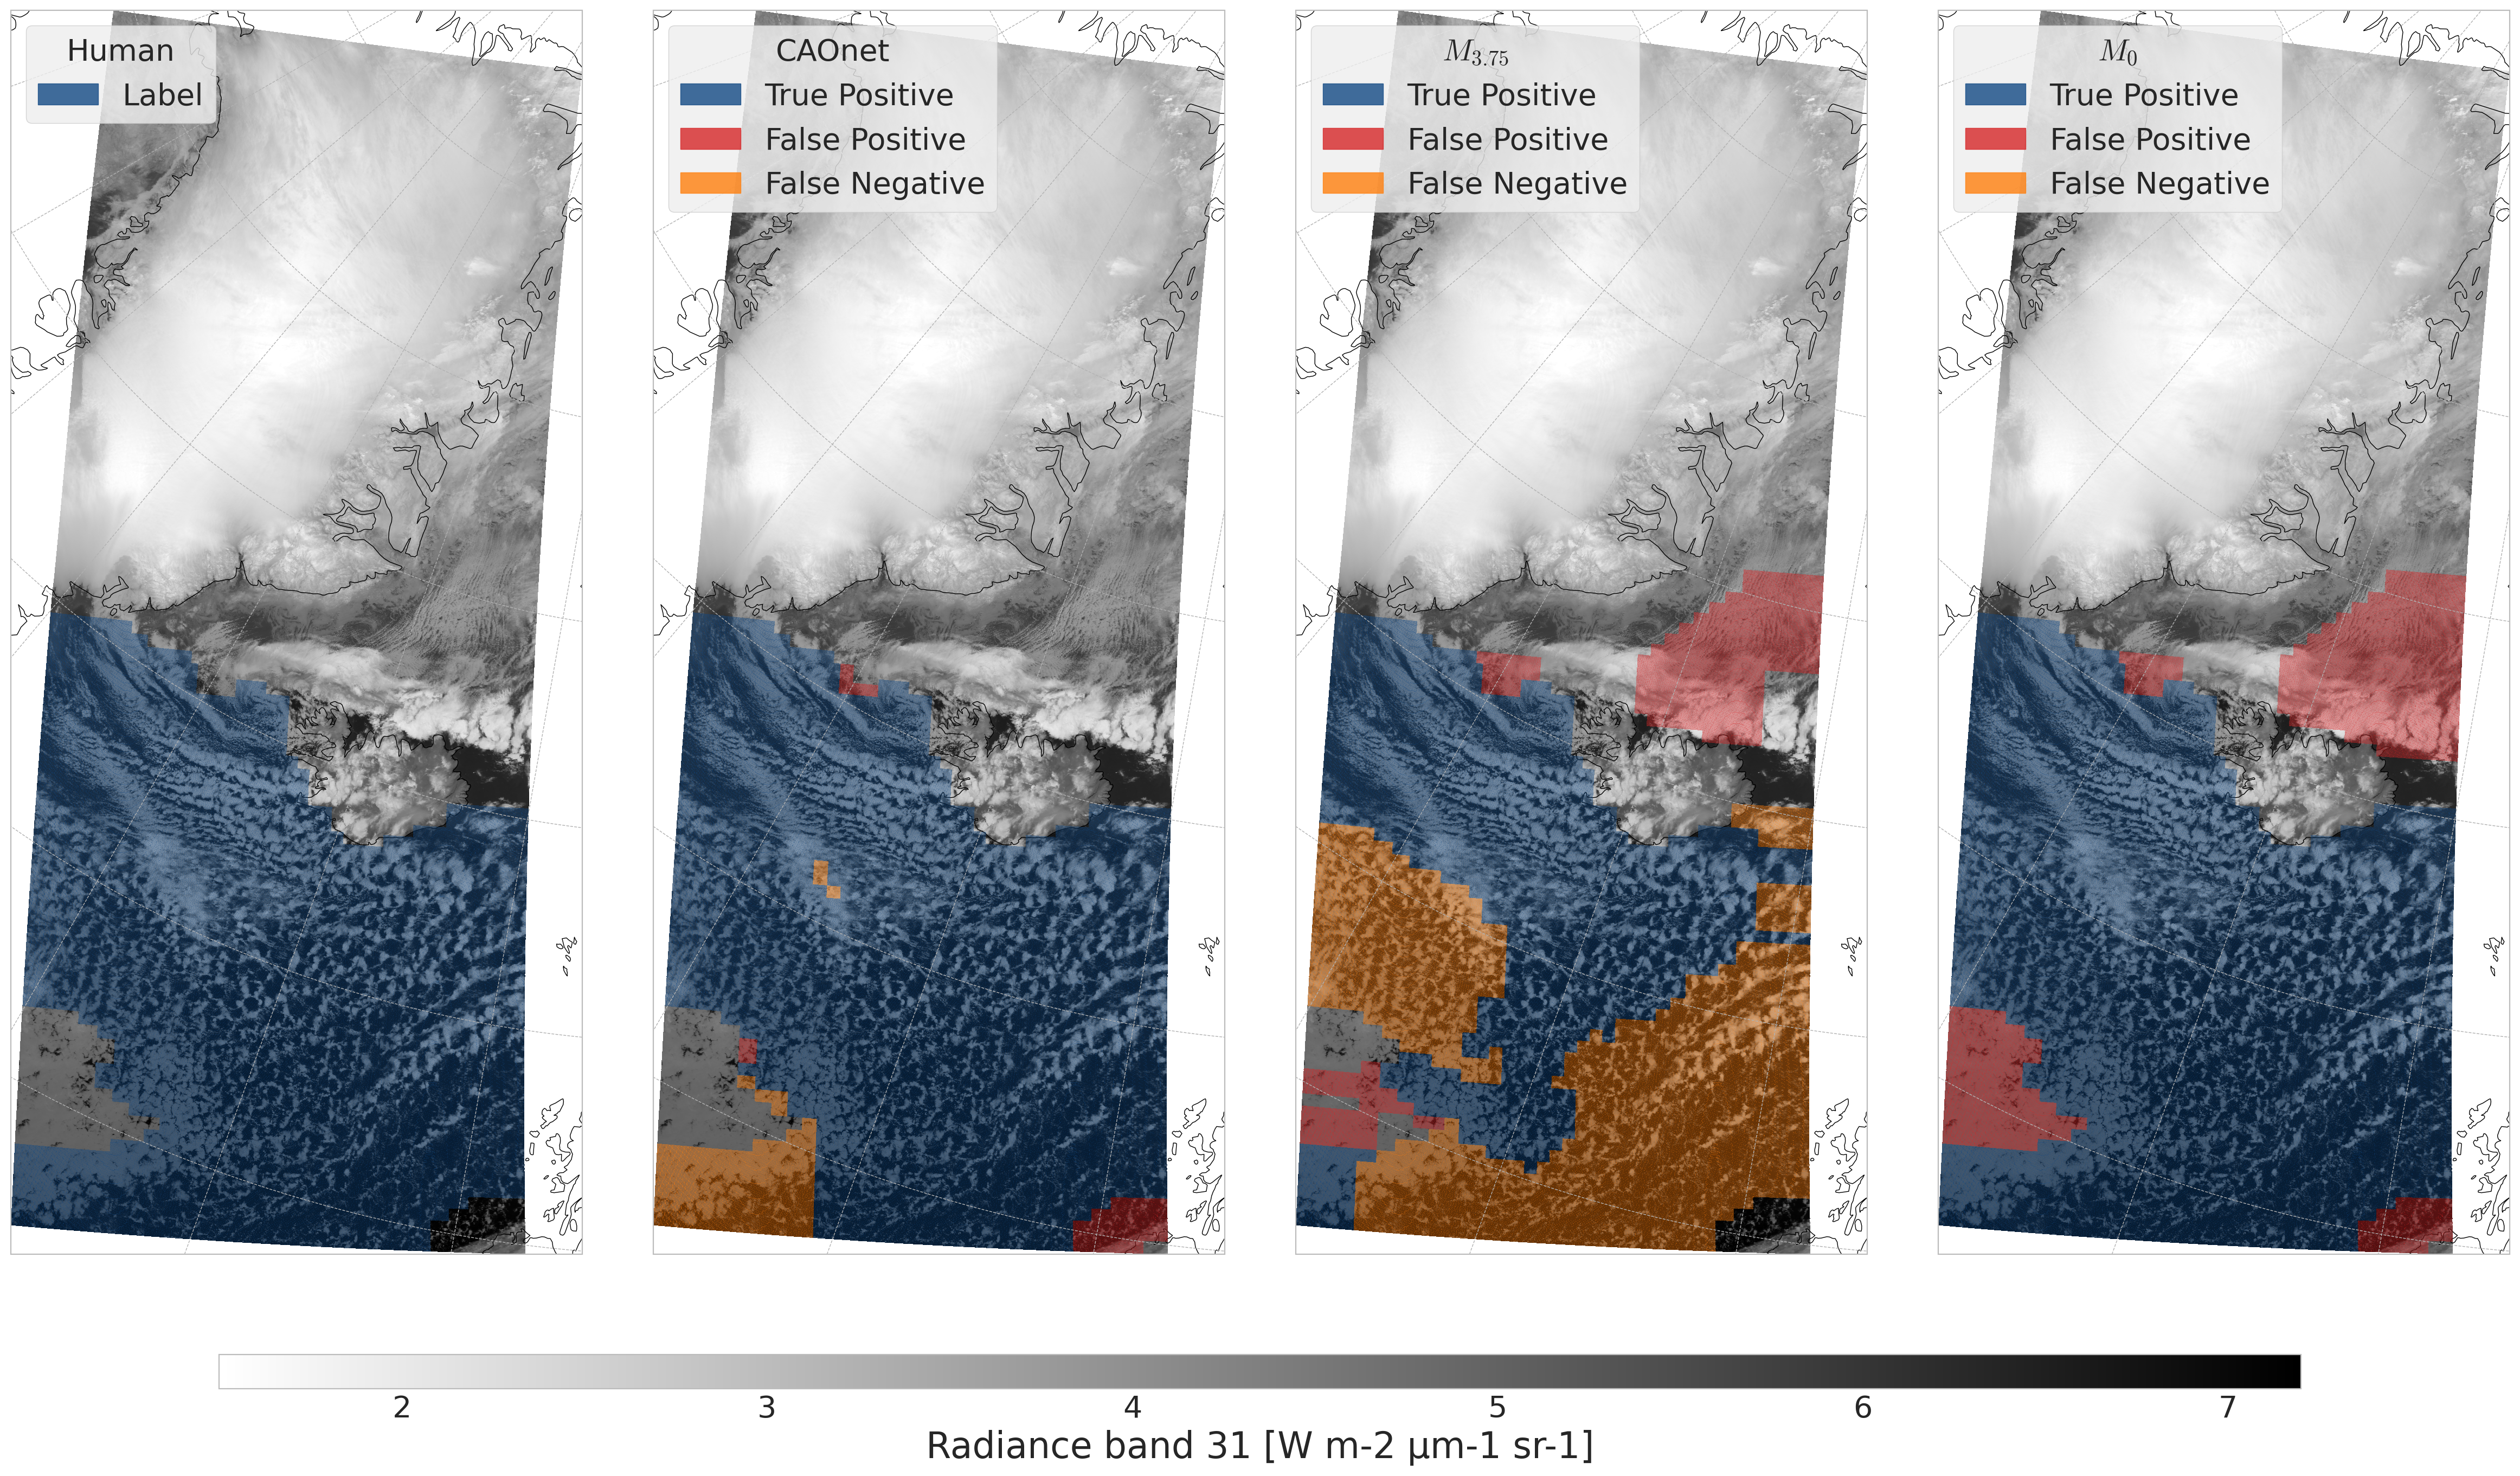

In [ ]:
split_size =  500
M_threshold = 3.75


for split_i in range(len(x_cao) // split_size + 1):
    split_to = min(split_size + split_i*split_size, len(x_cao))
    x_i  = x_cao[split_i*split_size : split_to]
    masks_i  = masks_cao[split_i*split_size : split_to]
    lon_lats_i  = lon_lats_cao[split_i*split_size : split_to]
    dates_i  = dates_cao[split_i*split_size : split_to]
    mod_min_i = mod_min_cao[split_i*split_size : split_to]
    ix = np.isin(dates_i, dates_to_plot)
    x_i  = [x_i[i] for i in np.where(ix)[0]]
    masks_i  = [masks_i[i] for i in np.where(ix)[0]]
    lon_lats_i  = [lon_lats_i[i] for i in np.where(ix)[0]]
    dates_i  = [dates_i[i] for i in np.where(ix)[0]]
    mod_min_i = [mod_min_i[i] for i in np.where(ix)[0]]

    patches_cao, all_lon_patches_cao, all_lat_patches_cao, starts_cao, ends_cao, shapes_cao, n_patches_tot_cao, indices_cao = generate_patches([x for x in x_i],
                                                                                                                                            masks_i,
                                                                                                                                            lon_lats_i,
                                                                                                                                            max_vals,
                                                                                                                                            min_vals,
                                                                                                                                            autoencoder_predict,
                                                                                                                                            strides=[1, strides, strides,1], 
                                                                                                                                            lon_lat_min_max=[-55, 65, 50, 82])

    encoded_patches_cao = encoder.predict(patches_cao, verbose=1)
    encoded_patches_flat_cao = encoded_patches_cao.reshape(encoded_patches_cao.shape[0], -1)

    labels = cluster.predict(encoded_patches_flat_cao)



    label_map, lon_map, lat_map = process_label_maps(labels,
                                                    all_lon_patches_cao,
                                                    all_lat_patches_cao,
                                                    starts_cao,
                                                    ends_cao,
                                                    shapes_cao,
                                                    indices_cao,
                                                    n_K,
                                                    n_patches_tot_cao,
                                                    patch_size,
                                                    strides,
                                                    [3,6], 
                                                    [], 
                                                    size_thr_1=15, 
                                                    size_thr_2=15)

    model_areas = process_model_area_mask(range(len(lon_map)), lon_map, lat_map, indices_cao, label_map, [3,6], [], plot=False)


    labeled_areas = get_area_masks(x_i,
                                    dates_i,
                                    mod_min_i,
                                    masks_i,
                                    filtered_data,
                                    subpixel_resolution=2,
                                    reduction=strides,
                                    index_list=range(len(x_i)),
                                    plot=False,)


    plot_comparisons(x_i, lon_map, lat_map, label_map, model_areas, labeled_areas, dates_i, mod_min_i, lon_lats_i, M_threshold, patch_size, strides, n_K, merra_folder)